In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib as plt
import libpysal
import esda
import spreg
import mapclassify
import folium 

import json

In [7]:
import os
os.chdir("..")
os.listdir()

['Final-project-Francesco-Danesi-Geospatial-Analysis']

In [8]:
prov = gpd.read_file("Data/ProvCM01012019/ProvCM01012019_WGS84.shp")

DataSourceError: Data/ProvCM01012019/ProvCM01012019_WGS84.shp: No such file or directory

Index(['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'DEN_PROV',
       'DEN_CM', 'DEN_UTS', 'SIGLA', 'TIPO_UTS', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry'],
      dtype='str')
(12, 3)


<Axes: >

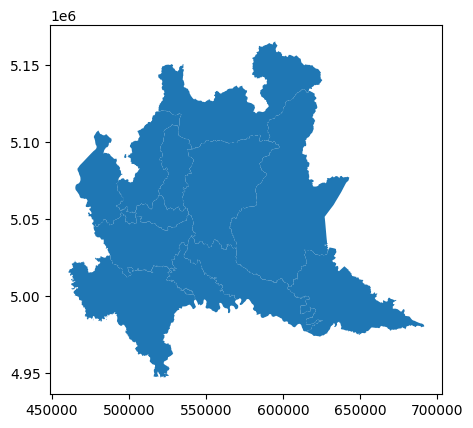

In [ ]:
print(prov.columns)

prov = prov[prov["COD_REG"] == 3]

prov = prov[["COD_PROV", "DEN_PROV", "geometry"]]

prov = prov.to_crs(epsg=32632)

print(prov.shape)
prov.plot()


In [ ]:
json_path = "Data/Causa - prov. (IT1,39_494_DF_DCIS_CMORTE1_RES_1,1.0).json"
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

if "structure" in data:
    structure = data["structure"]
else:
    structure = data["data"]["structure"]

dims_series = structure["dimensions"]["series"]
dims_obs = structure["dimensions"]["observation"]

def dim_index(name):
    return next(i for i, d in enumerate(dims_series) if d["id"] == name)

IDX_AREA = dim_index("REF_AREA")
IDX_TYPE = dim_index("DATA_TYPE")

time_values = dims_obs[0]["values"]
years = [int(v["id"]) for v in time_values]

records = []

series = data["data"]["dataSets"][0]["series"]

for key, content in series.items():
    key_parts = key.split(":")
    
    prov_code = dims_series[IDX_AREA]["values"][int(key_parts[IDX_AREA])]["id"]
    indicator = dims_series[IDX_TYPE]["values"][int(key_parts[IDX_TYPE])]["id"]
    
    if indicator != "MRATE":
        continue
    
    for t_idx, obs in content["observations"].items():
        records.append({
            "COD_PROV": prov_code,
            "year": years[int(t_idx)],
            "mort_rate": obs[0]
        })

mort = pd.DataFrame(records)

mort["mort_rate"] = pd.to_numeric(mort["mort_rate"], errors="coerce")
mort = (
    mort
    .groupby("COD_PROV", as_index=False)["mort_rate"]
    .mean()
)

prov[["COD_PROV", "DEN_PROV"]]
nuts_to_istat = {
    "ITC41": 12,   # Varese
    "ITC42": 13,   # Como
    "ITC43": 97,   # Lecco
    "ITC44": 14,   # Sondrio
    "ITC45": 15,   # Milano
    "ITC46": 16,   # Bergamo
    "ITC47": 17,   # Brescia
    "ITC48": 18,   # Pavia
    "ITC49": 98,   # Lodi
    "ITC4A": 19,   # Cremona
    "ITC4B": 20,   # Mantova
    "IT108": 108   # Monza
}
mort["COD_PROV"] = mort["COD_PROV"].map(nuts_to_istat)
prov = prov.merge(mort, on="COD_PROV", how="left")
prov.loc[prov["DEN_PROV"] == "-", "DEN_PROV"] = "Milano"
prov[["DEN_PROV", "mort_rate"]]


,DEN_PROV,mort_rate
0,Varese,29.931667
1,Como,28.601667
2,Sondrio,34.613333
3,Milano,28.515000
4,Bergamo,28.658333
5,Brescia,27.828333
6,Pavia,34.498333
7,Cremona,32.945000
8,Mantova,29.655000
9,Lecco,29.613333


In [ ]:
json_path = "Data/Contribuenti e principali categorie di reddito (IT1,30_1008_DF_MEF_REDDITIIRPEF_COM_1,1.0).json"

with open(json_path, "r", encoding="utf-8") as f:
    data_inc = json.load(f)

In [ ]:
if "structure" in data_inc:
    structure = data_inc["structure"]
else:
    structure = data_inc["data"]["structure"]

dims_series = structure["dimensions"]["series"]
dims_obs = structure["dimensions"]["observation"]

In [ ]:
for i, d in enumerate(dims_series):
    print(i, d["id"])

0 FREQ
1 REF_AREA
2 DATA_TYPE
3 AMOUNT_CLASS


In [ ]:
def dim_index(name):
    return next(i for i, d in enumerate(dims_series) if d["id"] == name)

IDX_AREA = dim_index("REF_AREA")
IDX_TYPE = dim_index("DATA_TYPE")

In [ ]:
time_values = dims_obs[0]["values"]
years = [int(v["id"]) for v in time_values]
years

[2019, 2020]

In [ ]:
YEAR_SELECTED = max(years)
YEAR_SELECTED

2020

In [ ]:
dims_series[IDX_TYPE]["values"]

[{'id': 'CADINCF',
  'order': 1,
  'name': 'contribuenti con reddito da fabbricati',
  'names': {'it': 'contribuenti con reddito da fabbricati',
   'en': 'taxpayers of cadastral income'}},
 {'id': 'CADINCR',
  'order': 2,
  'name': 'reddito da fabbricati (euro)',
  'names': {'it': 'reddito da fabbricati (euro)',
   'en': 'cadastral income (eur)'}},
 {'id': 'ENTROAINCF',
  'order': 9,
  'name': "contribuenti con reddito di spettanza dell'imprenditore in contabilità ordinaria (comprensivo dei valori nulli)",
  'names': {'it': "contribuenti con reddito di spettanza dell'imprenditore in contabilità ordinaria (comprensivo dei valori nulli)",
   'en': 'taxpayers of income earned by the entrepreneur in ordinary accounting (including null values)'}},
 {'id': 'ENTROAINCR',
  'order': 10,
  'name': "reddito di spettanza dell'imprenditore in contabilità ordinaria (comprensivo dei valori nulli) (euro)",
  'names': {'it': "reddito di spettanza dell'imprenditore in contabilità ordinaria (comprensivo

In [ ]:
records = []

series = data_inc["data"]["dataSets"][0]["series"]

for key, content in series.items():
    key_parts = key.split(":")
    
    area_code = dims_series[IDX_AREA]["values"][int(key_parts[IDX_AREA])]["id"]
    indicator = dims_series[IDX_TYPE]["values"][int(key_parts[IDX_TYPE])]["id"]
    
    if indicator != "TAXABINCR":
        continue
    
    for t_idx, obs in content["observations"].items():
        year = years[int(t_idx)]
        if year != YEAR_SELECTED:
            continue
        
        records.append({
            "COD_CM": str(area_code),
            "income": obs[0]
        })

income_com = pd.DataFrame(records)

In [ ]:
income_prov_long = income_com.rename(columns={"COD_CM": "COD_PROV"})

In [ ]:
income_prov_long["COD_PROV"] = pd.to_numeric(
    income_prov_long["COD_PROV"],
    errors="coerce"
)

In [ ]:
income_prov_long = income_prov_long[
    income_prov_long["COD_PROV"].isin(prov["COD_PROV"])
]

In [ ]:
registry = pd.read_excel("Data/Elenco-comuni-italiani.xlsx")

registry = registry.rename(columns={
    "Codice Comune formato numerico": "COD_CM",
    "Codice Provincia (Storico)(1)": "COD_PROV"
})

registry = registry[["COD_CM", "COD_PROV"]]

registry["COD_CM"] = registry["COD_CM"].astype(str).str.zfill(6)

registry["COD_PROV"] = pd.to_numeric(registry["COD_PROV"], errors="coerce")

In [ ]:
income_raw = income_com.merge(
    registry,
    on="COD_CM",
    how="left"
)

In [ ]:
income_raw["COD_PROV"].isna().sum()

np.int64(6)

In [ ]:
income_raw = income_raw[income_raw["COD_PROV"].isin(prov["COD_PROV"])]


In [ ]:
income_raw["income"] = pd.to_numeric(income_raw["income"], errors="coerce")


In [ ]:
income_prov = (
    income_raw
    .groupby("COD_PROV", as_index=False)["income"]
    .mean()
)

In [ ]:
prov = prov.merge(
    income_prov,
    on="COD_PROV",
    how="left"
)

In [ ]:
pop_prov = pd.DataFrame({
    "DEN_PROV": [
        "Varese", "Como", "Sondrio", "Milano", "Bergamo", "Brescia",
        "Pavia", "Cremona", "Mantova", "Lecco", "Lodi", "Monza e della Brianza"
    ],
    "population": [
        890000,   # Varese
        600000,   # Como
        180000,   # Sondrio
        3260000,  # Milano
        1120000,  # Bergamo
        1260000,  # Brescia
        540000,   # Pavia
        360000,   # Cremona
        410000,   # Mantova
        340000,   # Lecco
        230000,   # Lodi
        880000    # Monza
    ]
})


In [ ]:
prov = prov.merge(
    pop_prov,
    on="DEN_PROV",
    how="left"
)

In [ ]:
prov["income_pc"] = prov["income"] / prov["population"]


In [ ]:
prov.crs


<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
from libpysal.weights import Queen

In [ ]:
w = Queen.from_dataframe(prov)
w.transform = "r" 

/tmp/ipykernel_7916/2196661676.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(prov)


In [ ]:
from esda.moran import Moran


In [ ]:
y_mort = prov["mort_rate"].values
moran_mort = Moran(y_mort, w)

In [ ]:
moran_mort.I
moran_mort.p_sim

np.float64(0.024)

In [ ]:
y_inc = prov["income_pc"].values

moran_inc = Moran(y_inc, w)

moran_inc.I
moran_inc.p_sim

np.float64(0.08)

In [ ]:
import matplotlib.pyplot as plt
! pip install splot
from splot.esda import moran_scatterplot

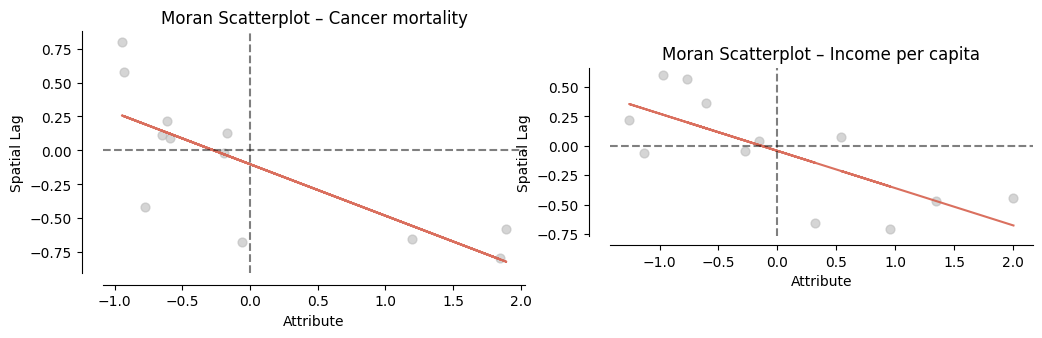

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

moran_scatterplot(moran_mort, ax=ax[0])
ax[0].set_title("Moran Scatterplot – Cancer mortality")

moran_scatterplot(moran_inc, ax=ax[1])
ax[1].set_title("Moran Scatterplot – Income per capita")

plt.show()


In [ ]:
from esda.moran import Moran_Local

In [ ]:
lisa_mort = Moran_Local(y_mort, w)

In [ ]:
prov["lisa_I_mort"] = lisa_mort.Is
prov["lisa_p_mort"] = lisa_mort.p_sim
prov["lisa_q_mort"] = lisa_mort.q

In [ ]:
prov["lisa_sig_mort"] = prov["lisa_p_mort"] < 0.05

In [ ]:
lisa_inc = Moran_Local(y_inc, w)

prov["lisa_q_inc"] = lisa_inc.q
prov["lisa_p_inc"] = lisa_inc.p_sim

In [ ]:
import numpy as np

prov["lisa_cluster_mort"] = "Not significant"

prov.loc[(prov["lisa_q_mort"] == 1) & (prov["lisa_p_mort"] < 0.05), "lisa_cluster_mort"] = "High-High"
prov.loc[(prov["lisa_q_mort"] == 2) & (prov["lisa_p_mort"] < 0.05), "lisa_cluster_mort"] = "Low-High"
prov.loc[(prov["lisa_q_mort"] == 3) & (prov["lisa_p_mort"] < 0.05), "lisa_cluster_mort"] = "Low-Low"
prov.loc[(prov["lisa_q_mort"] == 4) & (prov["lisa_p_mort"] < 0.05), "lisa_cluster_mort"] = "High-Low"


In [ ]:
prov[["DEN_PROV", "mort_rate", "lisa_cluster_mort"]]

,DEN_PROV,mort_rate,lisa_cluster_mort
0,Varese,29.931667,Not significant
1,Como,28.601667,Not significant
2,Sondrio,34.613333,Not significant
3,Milano,28.515000,Not significant
4,Bergamo,28.658333,Not significant
5,Brescia,27.828333,Not significant
6,Pavia,34.498333,High-Low
7,Cremona,32.945000,High-Low
8,Mantova,29.655000,Not significant
9,Lecco,29.613333,Not significant


In [ ]:
prov_wgs = prov.to_crs(epsg=4326)
geojson = prov_wgs.to_json()

In [ ]:
cluster_colors = {
    "High-High": "#d7191c",
    "Low-Low": "#2c7bb6",
    "High-Low": "#fdae61",
    "Low-High": "#abd9e9",
    "Not significant": "#cccccc"
}


In [ ]:
import folium

m = folium.Map(
    location=[45.5, 9.5],
    zoom_start=7,
    tiles="cartodbpositron"
)

In [ ]:
folium.GeoJson(
    geojson,
    style_function=lambda feature: {
        "fillColor": cluster_colors[
            prov_wgs.loc[
                prov_wgs["DEN_PROV"] == feature["properties"]["DEN_PROV"],
                "lisa_cluster_mort"
            ].values[0]
        ],
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["DEN_PROV", "mort_rate", "lisa_cluster_mort"],
        aliases=["Province:", "Mortality rate:", "LISA cluster:"],
        localize=True
    )
).add_to(m)

m.save("explorative_map.html")

In [ ]:
lisa_inc = Moran_Local(y_inc, w)

prov["lisa_cluster_inc"] = "Not significant"
prov.loc[(lisa_inc.q == 1) & (lisa_inc.p_sim < 0.05), "lisa_cluster_inc"] = "High-High"
prov.loc[(lisa_inc.q == 2) & (lisa_inc.p_sim < 0.05), "lisa_cluster_inc"] = "Low-High"
prov.loc[(lisa_inc.q == 3) & (lisa_inc.p_sim < 0.05), "lisa_cluster_inc"] = "Low-Low"
prov.loc[(lisa_inc.q == 4) & (lisa_inc.p_sim < 0.05), "lisa_cluster_inc"] = "High-Low"


step 6

In [ ]:
geojson = prov_wgs.to_json()
import folium

base_location = [45.5, 9.5]

In [ ]:
m_mort = folium.Map(
    location=base_location,
    zoom_start=7,
    tiles="cartodbpositron"
)

folium.Choropleth(
    geo_data=geojson,
    data=prov_wgs,
    columns=["DEN_PROV", "mort_rate"],
    key_on="feature.properties.DEN_PROV",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.6,
    legend_name="Cancer mortality rate",
).add_to(m_mort)

folium.GeoJson(
    geojson,
    tooltip=folium.GeoJsonTooltip(
        fields=["DEN_PROV", "mort_rate"],
        aliases=["Province:", "Mortality rate:"],
        localize=True
    )
).add_to(m_mort)

m_mort.save("mortality_map.html")

In [ ]:
m_inc = folium.Map(
    location=base_location,
    zoom_start=7,
    tiles="cartodbpositron"
)

folium.Choropleth(
    geo_data=geojson,
    data=prov_wgs,
    columns=["DEN_PROV", "income_pc"],
    key_on="feature.properties.DEN_PROV",
    fill_color="YlGnBu",
    fill_opacity=0.8,
    line_opacity=0.6,
    legend_name="Income per capita (€)",
).add_to(m_inc)

folium.GeoJson(
    geojson,
    tooltip=folium.GeoJsonTooltip(
        fields=["DEN_PROV", "income_pc"],
        aliases=["Province:", "Income per capita (€):"],
        localize=True,
        sticky=False
    )
).add_to(m_inc)

m_inc.save("income_map.html")


In [ ]:
m_combined = folium.Map(
    location=[45.5, 9.5],
    zoom_start=7,
    tiles="cartodbpositron"
)

folium.Choropleth(
    geo_data=geojson,
    data=prov_wgs,
    columns=["DEN_PROV", "mort_rate"],
    key_on="feature.properties.DEN_PROV",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Cancer mortality rate",
    name="Cancer mortality",
    show=True
).add_to(m_combined)

folium.Choropleth(
    geo_data=geojson,
    data=prov_wgs,
    columns=["DEN_PROV", "income_pc"],
    key_on="feature.properties.DEN_PROV",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Income per capita (€)",
    name="Income per capita",
    show=False
).add_to(m_combined)

folium.LayerControl(collapsed=False).add_to(m_combined)

m_combined.save("combined_map.html")

In [ ]:
! pip install statsmodels
import statsmodels.api as sm

X = prov[["income_pc"]]
y = prov["mort_rate"]

X = sm.add_constant(X)

In [ ]:
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:              mort_rate   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.3561
Date:                Thu, 12 Feb 2026   Prob (F-statistic):              0.564
Time:                        15:22:20   Log-Likelihood:                -27.327
No. Observations:                  12   AIC:                             58.65
Df Residuals:                      10   BIC:                             59.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.9985      1.723     17.989      0.0

In [ ]:

prov["log_income_pc"] = np.log(prov["income_pc"])

X_log = sm.add_constant(prov[["log_income_pc"]])
ols_log = sm.OLS(y, X_log).fit()

print(ols_log.summary())

                            OLS Regression Results                            
Dep. Variable:              mort_rate   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.091
Method:                 Least Squares   F-statistic:                   0.08264
Date:                Thu, 12 Feb 2026   Prob (F-statistic):              0.780
Time:                        15:22:20   Log-Likelihood:                -27.488
No. Observations:                  12   AIC:                             58.98
Df Residuals:                      10   BIC:                             59.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            32.2330      7.557      4.265

In [ ]:
residuals = ols_model.resid.values

from esda.moran import Moran
moran_resid = Moran(residuals, w)

moran_resid.I, moran_resid.p_sim

(np.float64(-0.39224909937492763), np.float64(0.021))

In [ ]:
import os
os.getcwd()

'/home/user/venv/lib/python3.12/site-packages'